[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)




#Connection to the drive and loading of libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 5.6 MB/s eta 0:00:00


In [3]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

import scipy.io as sio
import os
import requests

#Training setting

In [4]:
train_setting = {

    'path': '/content/drive/MyDrive/prova_github_Dataset/',

    'decay_train'     :True,
    'thr_train'       :False,
    'bias'            :False,

    '1beta4layer'     :False,
    'beta_out_single' :False,
    '1thr4layer'      :True,

    'lr' : 1e-3,

    'epochs': 10,
    'batch': 10,
    'training_ratio' : [0.8, 0.1, 0.1],

    'hyperparams': [64, 128, 64],
    'thr_init' : 0.1,
    'bet_init': 0.9,

    'reset': "subtract",
}

#Loading dataset
To ensure the script works, it is enough to have a dataset formatted in the following way:
training_input [window_index, input_variables, window_length], training_output [window_index, output_variables, window_length]. The same goes for test_output and test_input.

In [5]:
Dataset_input = np.load(train_setting['path'] + 'Dataset_input.npy')
Dataset_output = np.load(train_setting['path'] + 'Dataset_output.npy')

n_Windows = Dataset_input.shape[0]
n_train   = round(train_setting['training_ratio'][0] * n_Windows)
n_val     = round(train_setting['training_ratio'][1] * n_Windows)
n_test    = round(train_setting['training_ratio'][2] * n_Windows)

training_input  =  Dataset_input[0:n_train, :, :]
training_output = Dataset_output[0:n_train, :, :]

validation_input  =  Dataset_input[n_train:n_train+n_val, :, :]
validation_output = Dataset_output[n_train:n_train+n_val, :, :]

test_input  =  Dataset_input[n_train+n_val:, :, :]
test_output = Dataset_output[n_train+n_val:, :, :]

print(f"training_input {training_input.shape}")
print(f"training_output {training_output.shape}\n")

print(f"validation_input {validation_input.shape}")
print(f"validation_output {validation_output.shape}\n")

print(f"test_input {test_input.shape}")
print(f"test_output {test_output.shape}")

training_input (135, 96, 3876)
training_output (135, 2, 3876)

validation_input (17, 96, 3876)
validation_output (17, 2, 3876)

test_input (17, 96, 3876)
test_output (17, 2, 3876)


#Saving train setting

In [6]:
import datetime
data = str(datetime.datetime.now())
data = ((data[0:16].replace(" ", "_")).replace("-","_")).replace(":","_")

trained_folder = '/content/drive/MyDrive/Results/' + data
os.makedirs(trained_folder, exist_ok=True)

with open(trained_folder + "/0parametri_training.txt", "w") as f_save:
  f_save.write(train_setting['path'] + '\n')
  for chiave in train_setting:
    f_save.write("{} = {} \n".format(chiave, train_setting[chiave]))

#Create Datasets

In [7]:
class RegressionDataset(torch.utils.data.Dataset):

    def __init__(self, target, spike_in):
        self.num_samples = target.shape[0]
        timesteps = target.shape[2]

        target   = target.astype(np.float32)
        spike_in = spike_in.astype(np.float32)

        labels_target = []
        lista = []
        for i in range(self.num_samples):
          target_i = target[i, :, :]
          target_i = np.transpose(target_i, (1, 0))
          labels_target.append(torch.from_numpy(target_i))

          spike_ing = spike_in[i, :, :]
          spike_ing = np.transpose(spike_ing, (1, 0))
          lista.append(torch.from_numpy(spike_ing))

        self.labels   = torch.stack(labels_target, dim=1)
        self.features = torch.stack(lista, dim=1)


    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]



training_dataset = RegressionDataset(target=training_output, spike_in = training_input)
train_loader     = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=train_setting['batch'], drop_last=False)

validation_dataset = RegressionDataset(target=validation_output, spike_in = validation_input)
validation_loader  =  torch.utils.data.DataLoader(dataset=validation_dataset,  batch_size=train_setting['batch'], drop_last=True)

test_dataset = RegressionDataset(target=test_output, spike_in = test_input)
test_loader =  torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 1, drop_last=False)


for data, target in train_loader:
    print("Dimensioni dei dati:", data.shape)
    print("Dimensioni del target:", target.shape)
    print("Finestre Training :", len(train_loader))
    break  # Uscire dopo il primo batch

Dimensioni dei dati: torch.Size([10, 3876, 96])
Dimensioni del target: torch.Size([10, 3876, 2])
Finestre Training : 14


#Construct Model


In [8]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, input = 1, target_variables = 1):
        super().__init__()

        l0 = train_setting['hyperparams'][0]
        l1 = train_setting['hyperparams'][1]
        l2 = train_setting['hyperparams'][2]

        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        if train_setting['1thr4layer']:
          thr_in       = train_setting['thr_init']
          thr_hidden   = train_setting['thr_init']
          thr_hidden2  = train_setting['thr_init']
        else:
          thr_in      = torch.ones(l0)*train_setting['thr_init']
          thr_hidden  = torch.ones(l1)*train_setting['thr_init']
          thr_hidden2 = torch.ones(l2)*train_setting['thr_init']

        if train_setting['1beta4layer']:
          beta_in      = train_setting['bet_init']
          beta_hidden  = train_setting['bet_init']
          beta_hidden2 = train_setting['bet_init']
          beta_out     = train_setting['bet_init']
        else:
          beta_in      = torch.ones(l0)*train_setting['bet_init']
          beta_hidden  = torch.ones(l1)*train_setting['bet_init']
          beta_hidden2 = torch.ones(l2)*train_setting['bet_init']
          beta_out     = torch.ones(target_variables)*train_setting['bet_init']
          if train_setting['beta_out_single']:
            beta_out   = train_setting['bet_init']


        # layer 1
        self.fc_in = torch.nn.Linear(in_features=input, out_features=l0, bias = train_setting['bias'])
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=l0, out_features=l1, bias = train_setting['bias'])
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 3
        self.fc_hidden2 = torch.nn.Linear(in_features=l1, out_features=l2, bias = train_setting['bias'])
        self.lif_hidden2 = snn.Leaky(beta=beta_hidden2, threshold=thr_hidden2, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 4: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=l2, out_features = target_variables, bias = train_setting['bias'])
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, reset_mechanism="none")


    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_22 = self.lif_hidden2.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_hidden2 = self.fc_hidden2(spk_hidden)
            spk_hidden2, mem_22 = self.lif_hidden2(cur_hidden2, mem_22)

            cur_out = self.fc_out(spk_hidden2)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        out = torch.stack(mem_3_rec)

        return out


In [9]:
n_last = training_output.shape[1]
steps  = training_input.shape[2]

if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')

model = Net(timesteps=steps, input = 96, target_variables = n_last).to(device)

cpu


#Construct Training Loop

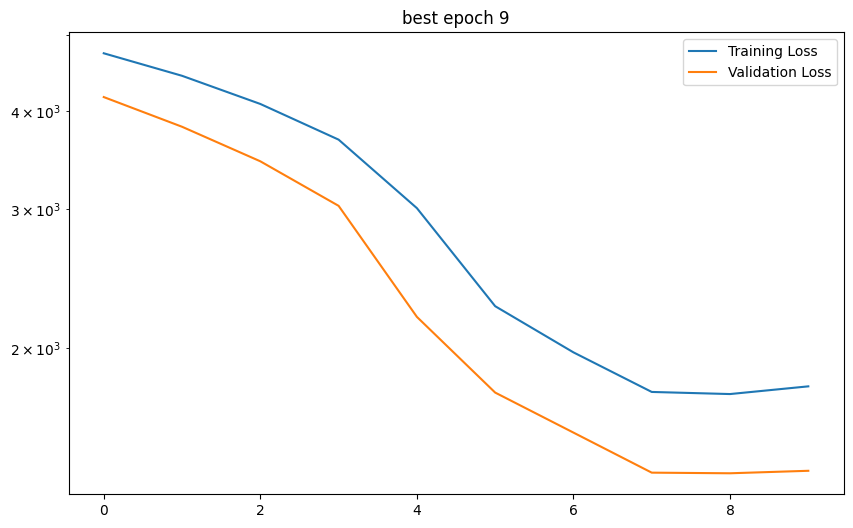

100%|██████████| 10/10 [29:09<00:00, 174.92s/it, loss=1.788e+03]


In [10]:
num_iter = train_setting['epochs']
optimizer = torch.optim.Adam(params=model.parameters(), lr=train_setting['lr'])
loss_function = torch.nn.MSELoss()

loss_hist   = []
v_loss_hist = []
v_loss_best = 1e10
epoca = 0

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(train_loader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            # prepare data
            feature = feature.to(device)
            label   = label.to(device)

            feature =torch.swapaxes(input=feature, axis0=0, axis1=1)
            label   = torch.swapaxes(input=label, axis0=0, axis1=1)

            # forward pass
            mem     = model(feature)

            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward()   # calculate gradients
            optimizer.step()      # update weights

            # store loss
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)       # print loss p/batch

        loss_hist.append(avg_batch_loss)
        epoca = epoca + 1
        torch.save(model.state_dict(), trained_folder +  '/network')

        model.eval()
        vloss_sum = 0
        with torch.no_grad():
          for v_feature, v_label in validation_loader:
            v_feature = torch.swapaxes(input=v_feature, axis0=0, axis1=1)
            v_label   = torch.swapaxes(input=v_label, axis0=0, axis1=1)
            voutputs = model(v_feature)
            vloss_sum += loss_function(voutputs, v_label)
          vloss = vloss_sum.mean()
          v_loss_hist.append(vloss)
          if vloss < v_loss_best:
            best_epoch = epoca
            v_loss_best = vloss
            torch.save(model.state_dict(), trained_folder + '/network_best')


        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.semilogy(loss_hist, label='Training Loss')
        plt.semilogy(v_loss_hist, label = 'Validation Loss')
        plt.title('best epoch {}'.format(best_epoch))
        plt.legend()
        plt.show()

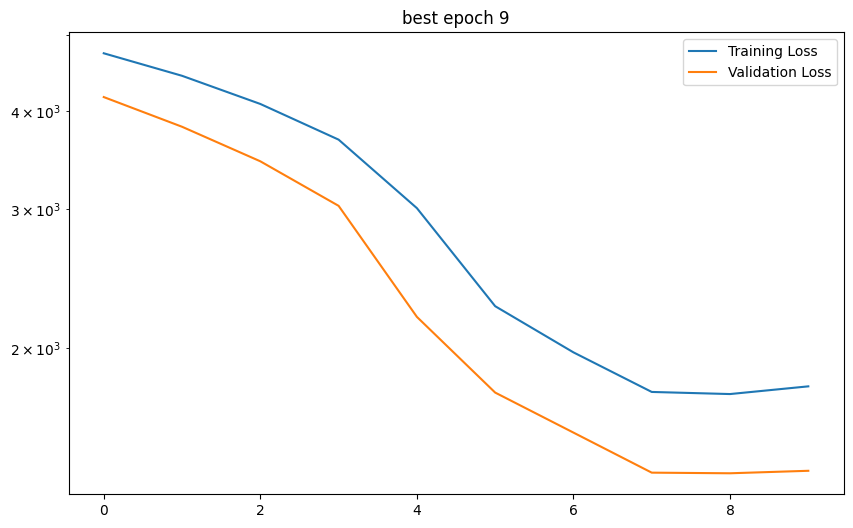

In [11]:
plt.figure(figsize=(10, 6))
plt.semilogy(loss_hist, label='Training Loss')
plt.semilogy(v_loss_hist, label = 'Validation Loss')
plt.title('best epoch {}'.format(best_epoch))
plt.legend()
plt.savefig(trained_folder + '/loss.png')

#Evaluation

Inferences computing

In [12]:
model.load_state_dict(torch.load(trained_folder + '/network_best'))

inference = []

 # pause gradient calculation during evaluation
with torch.no_grad():

    # loop over data samples
    for feature, label in test_loader:

        feature =torch.swapaxes(input=feature, axis0=0, axis1=1)
        label   = torch.swapaxes(input=label, axis0=0, axis1=1)

        # prepare data
        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model(feature)
        inference.append(mem.detach().squeeze().numpy())

<ipython-input-12-0bf49fec4d37>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_folder + '/network_best'))


Storing model

In [13]:
def CC(gt, inference):
  return np.corrcoef(gt, inference)[0, 1]

def Rsquare(gt, inference):
    num = np.square(gt - inference)
    den = np.square(gt - np.mean(gt))
    return 1 - np.sum(num)/np.sum(den)

trained_output = np.array(inference)

test_windows = test_output.shape[0]

R  = np.zeros((test_windows, n_last))
Cc = np.zeros((test_windows, n_last))

for var in range(n_last):
  for i in range(test_windows):
    R [i, var] = Rsquare(test_output[i, var, :], trained_output[i, :, var])
    Cc[i, var] = CC(test_output[i, var, :], trained_output[i, :, var])

print(f"Mean R^2 value: x-axis {R[:, 0].mean()} y-axis {R[:, 1].mean()}")
print(f"Mean CC value: x-axis {Cc[:, 0].mean()} y-axis {Cc[:, 1].mean()}")

with open(trained_folder + '/Results.txt', "w") as fw:
  fw.write(f"Mean R^2 value: x-axis {R[:, 0].mean()} y-axis {R[:, 1].mean()} \n")
  fw.write(f"Mean CC value: x-axis {Cc[:, 0].mean()} y-axis {Cc[:, 1].mean()}")

Mean R^2 value: x-axis 0.46256597240897807 y-axis 0.5474998933422431
Mean CC value: x-axis 0.786253989068313 y-axis 0.8157080332709684


#Plot

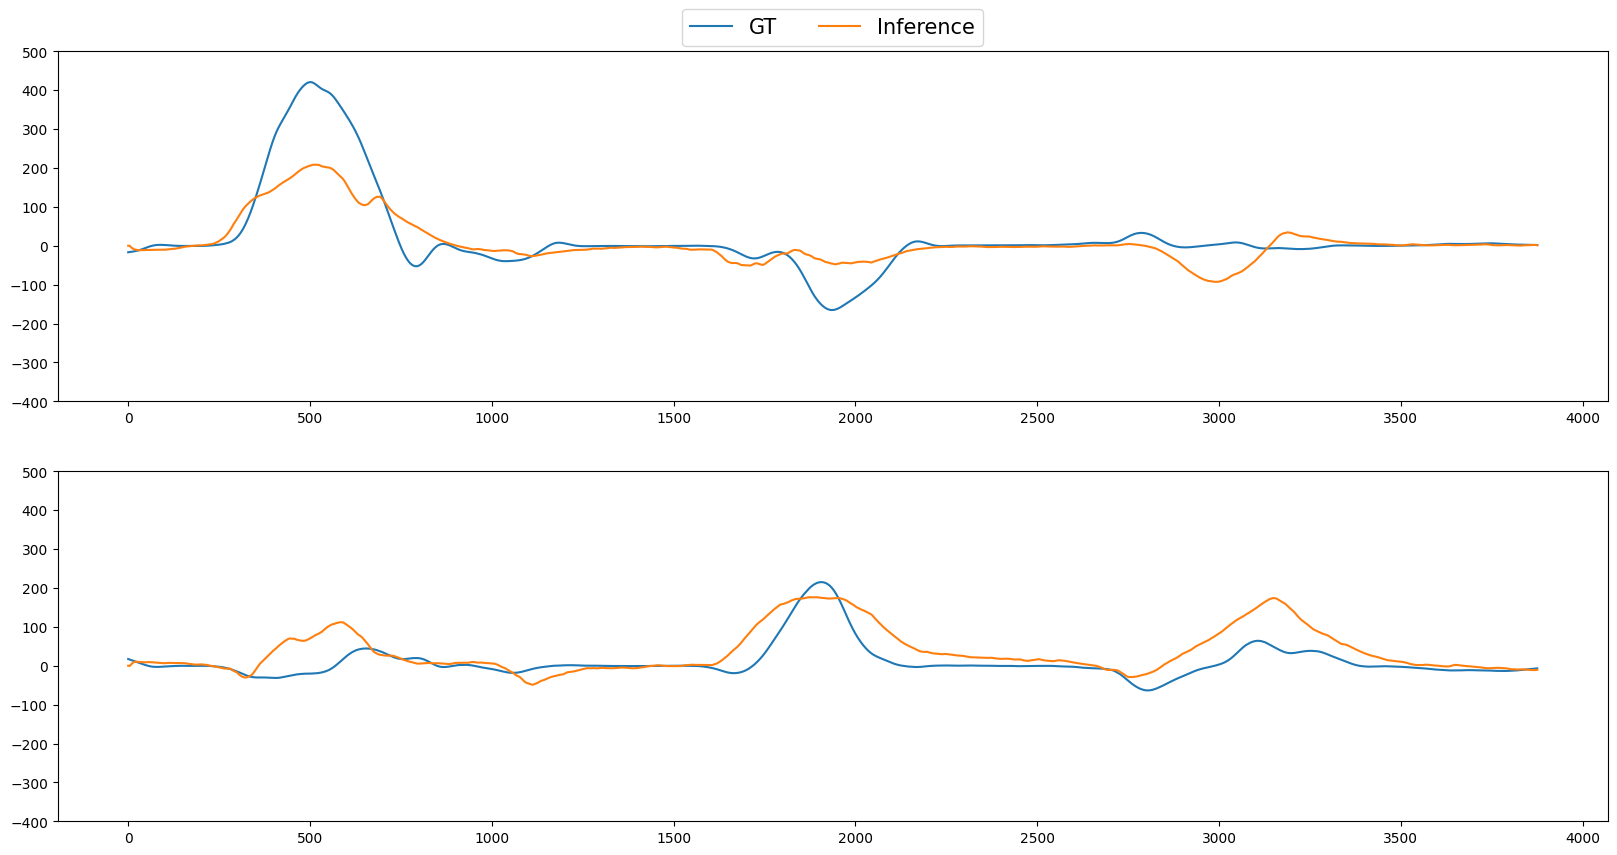

In [14]:
plt.figure(figsize=(20, 10))

sel_index = 0

for var_out in range(n_last):

  axs = plt.subplot(n_last, 1, var_out + 1)
  axs.plot(test_output[sel_index, var_out], label='GT')
  axs.plot(trained_output[sel_index,:, var_out], label="Inference")
  axs.set_ylim([-400, 500])

axs.legend(loc='upper center', bbox_to_anchor=(0.5, 2.35), ncol=2, fontsize = 15)
plt.savefig(trained_folder + '/behave.png')